`python3.11 -m pip install jupyterlab PyEnchant scipy numpy spotipy scikit-learn matplotlib mpl-tools seaborn --user`

# Init

In [1]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [2]:
##### Session Database Params #####
_MOD_T_DAY_S  = 60.0 * 60 * 24
_STALE_TIME_S = _MOD_T_DAY_S * 31
_MIN_LEN_S    = 60.0 + 45.0
_NULL_GENRE   = "Music"
_DATA_DIR     = "data/"
_DATA_PREFIX  = "Study-Music-Data_"

In [3]:
from ShuffleSoGood import (init_session_database, update_music_database, load_music_database, 
                           save_music_database, genre_vector_ops)
data, timestamp, outFilNam, outPath = init_session_database()

In [4]:
load_music_database( data, _DATA_DIR, _DATA_PREFIX, forceLoad = 1 );

Loaded data/Study-Music-Data_2024-10-13T16:03:14.pkl!


In [5]:

def get_mini_genre_dataset( db ):
    """ Return the data and labels as separate items """
    N_tot = 0

    gnreIDs = sorted( list( db['genres'].keys() ) )
    gnrNams = [db['genres'][ genreID_i ]['nameLocal'] for genreID_i in gnreIDs]
    
    # Count track vectors
    for genreID_i, genre_i in db['genres'].items():
        if not len( genre_i['vectors'] ):
            genre_vector_ops( genre_i )
        N_tot += len( genre_i['vectors'] )

    X = [None for _ in range( N_tot )]
    Y = [None for _ in range( N_tot )]
    J = 0

    # Gather track vectors
    for i, genreID_i in enumerate( gnreIDs ):
        genre_i   = db['genres'][ genreID_i ]
        vectors_i = genre_i['vectors']
        for vec in vectors_i:
            X[J] = vec
            Y[J] = i
            J   += 1

    return np.array(X), np.array(Y), gnrNams
        
    

In [6]:
X, Y, gnrNams = get_mini_genre_dataset( data )
len( X )

4424

In [7]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame( X, columns = feat_cols )
df['y'] = Y
df['label'] = df['y'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (4424, 12)


In [8]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.36941058 0.25930167 0.14552153]


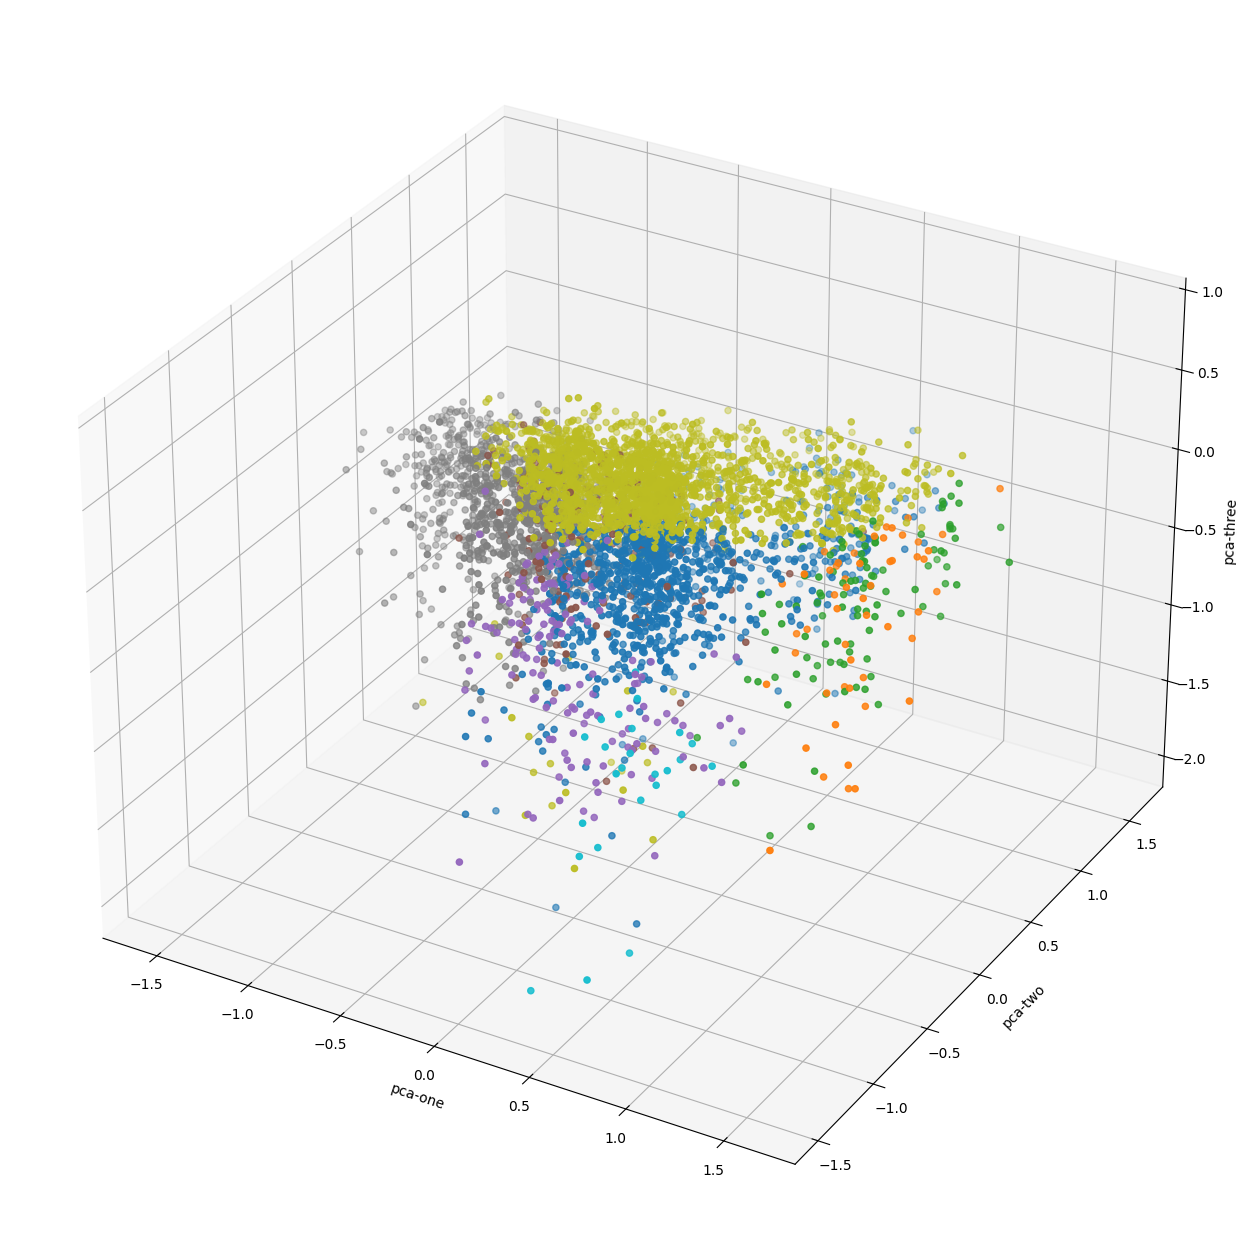

In [12]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

fig = plt.figure( figsize=(16,16) )
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()